# Market Basket Analysis of an Online Retailer using R

Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

The dataset we are using today comes from [UCI Machine Learning repository](https://archive.ics.uci.edu/). The dataset is called “Online Retail” and can be found [here](https://archive.ics.uci.edu/dataset/352/online+retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered online retailer. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.




In [ ]:
#Import Packages
library(tidyverse)
library(readxl)
library(knitr)
library(ggplot2)
library(lubridate)
library(data.table)
library(dplyr)
library(knitr)
library(stringr)


In [ ]:

install.packages("DT")
library(DT)
install.packages("plotly")
library(plotly)
install.packages("visNetwork")
library(visNetwork)
install.packages("igraph")
library(igraph)
#install.packages("kableExtra")
#library(kableExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following object is masked from ‘package:plotly’:

    groups


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [ ]:
install.packages("plyr")
library(plyr)

In [ ]:
install.packages("arules")
library(arules)

In [ ]:

install.packages("arulesViz")
library(arulesViz)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘seriation’, ‘vcd’, ‘ggraph’




# Data preprocessing and exploring

In [ ]:
retail <- read_excel('/content/Online Retail.xlsx')
#remove incomplete rows
retail <- retail[complete.cases(retail), ]
#formating variables
retail <- retail %>% mutate(Description = as.factor(Description))
retail <- retail %>% mutate(Country = as.factor(Country))
retail$Date <- as.Date(retail$InvoiceDate)
retail$Time <- as.POSIXct(retail$InvoiceDate,"%H:%M:%S")
retail$InvoiceNo <- as.numeric(as.character(retail$InvoiceNo))


In [ ]:
glimpse(retail)

Rows: 406,829
Columns: 10
$ InvoiceNo   <dbl> 536365, 536365, 536365, 536365, 536365, 536365, 536365, 53…
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752", …
$ Description <fct> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN…
$ Quantity    <dbl> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, …
$ InvoiceDate <dttm> 2010-12-01 08:26:00, 2010-12-01 08:26:00, 2010-12-01 08:2…
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69…
$ CustomerID  <dbl> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17…
$ Country     <fct> United Kingdom, United Kingdom, United Kingdom, United Kin…
$ Date        <date> 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-01, 2010-12-0…
$ Time        <chr> "08:26:00", "08:26:00", "08:26:00", "08:26:00", "08:26:00"…


After preprocessing, the dataset includes 406,829 records and 10 fields: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Date, Time.



#First Question: **What time do people often purchase online?**
In order to find the answer to this question, we need to extract “hour” from the time column.




Warning message in geom_histogram(stat = "count", fill = "indianred"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


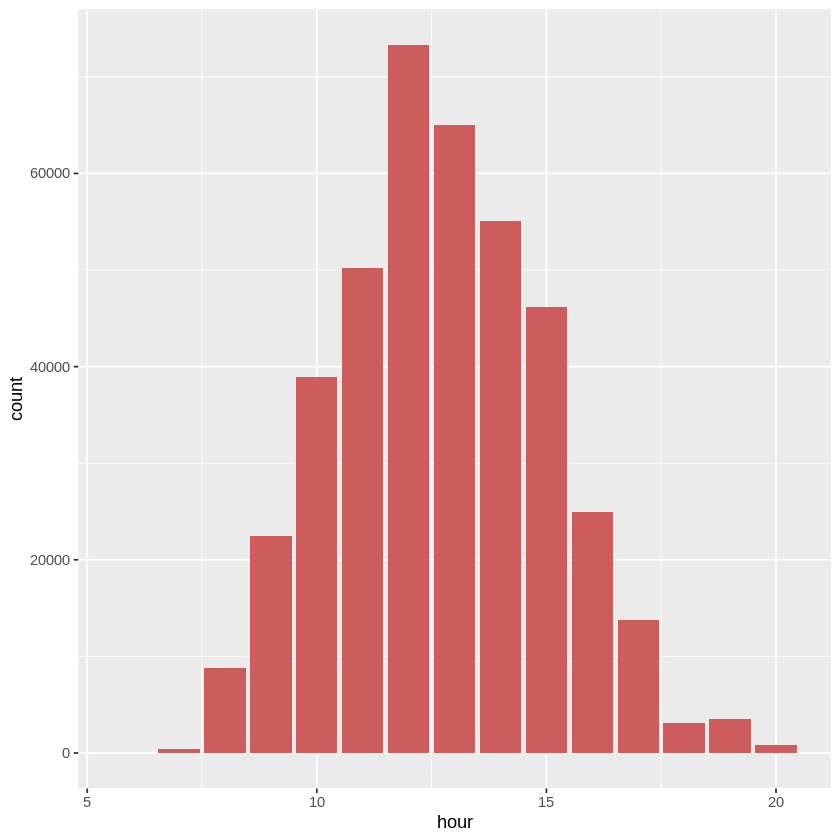

In [ ]:
retail$hour <- lubridate::hour(retail$Time)

retail %>%
  ggplot(aes(x=hour)) +
  geom_histogram(stat="count",fill="indianred")


There is a clear bias between the hour of day and order volume. Most orders happened between 10:00–15:00.



#Second Question: **How many orders each customer made?**

Let's group by customerID


# A tibble: 4,372 × 2
   CustomerID Orders
        <dbl>  <int>
 1      12346      2
 2      12347      7
 3      12348      4
 4      12349      1
 5      12350      1
 6      12352      9
 7      12353      1
 8      12354      1
 9      12355      1
10      12356      3
# ℹ 4,362 more rows


Warning message in geom_histogram(stat = "count", fill = "indianred"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


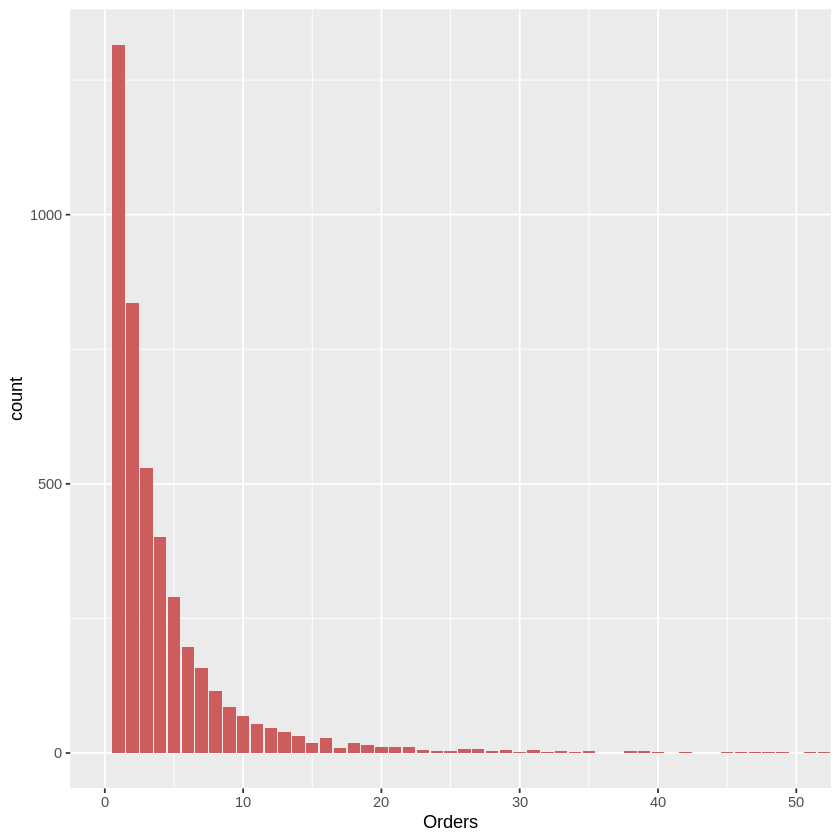

In [ ]:
# Group by CustomerID and count the number of orders made by each customer
orders_per_customer <- retail %>%
  group_by(CustomerID) %>%
  summarize(Orders = n_distinct(InvoiceNo))

# Print the result
print(orders_per_customer)

orders_per_customer %>%
  ggplot(aes(x=Orders)) +
    coord_cartesian(xlim = c(0, 50)) +

  geom_histogram(stat="count",fill="indianred")


Most customers made 1-3 orders

#Third Question: **How many items were bought in each order?**

Let's group by InvoiceNO


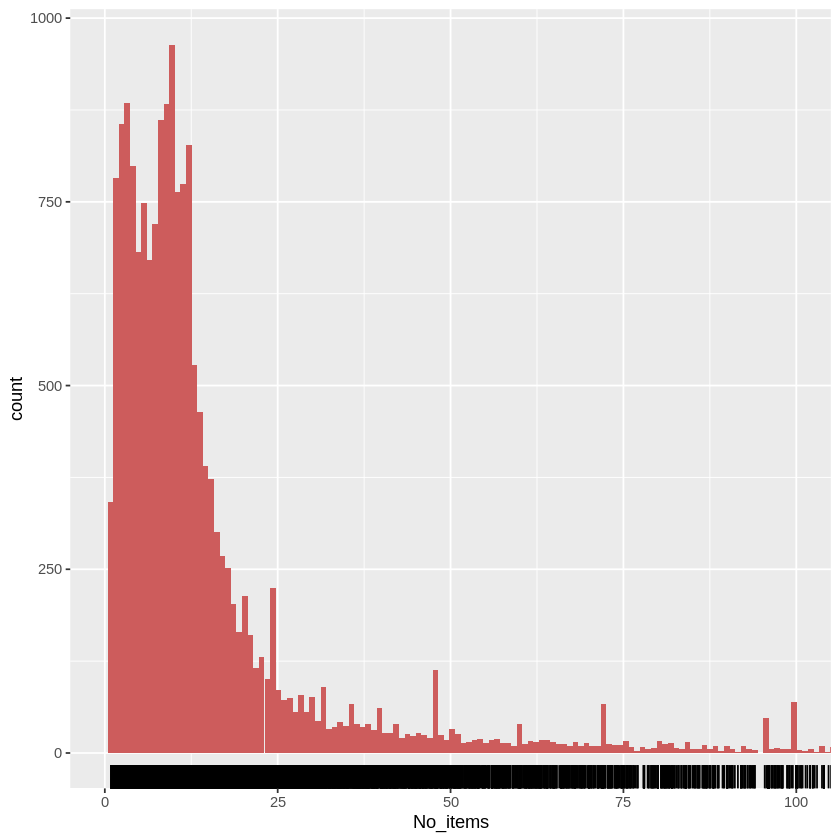

In [ ]:
items_per_customer <- retail %>%
  group_by(InvoiceNo) %>%
  summarise(No_items = mean(Quantity))

items_per_customer %>%
  ggplot(aes(x = No_items)) +
  geom_histogram(bins = 100000, fill = "indianred") +
  geom_rug() +
  coord_cartesian(xlim = c(0, 100))




People mostly purchased less than 10 items (less than 10 items in each invoice).



#Fourth Question: **Top 10 sellers**

Let's check which items are our best sellers!

`summarise()` has grouped output by 'StockCode'. You can override using the
`.groups` argument.


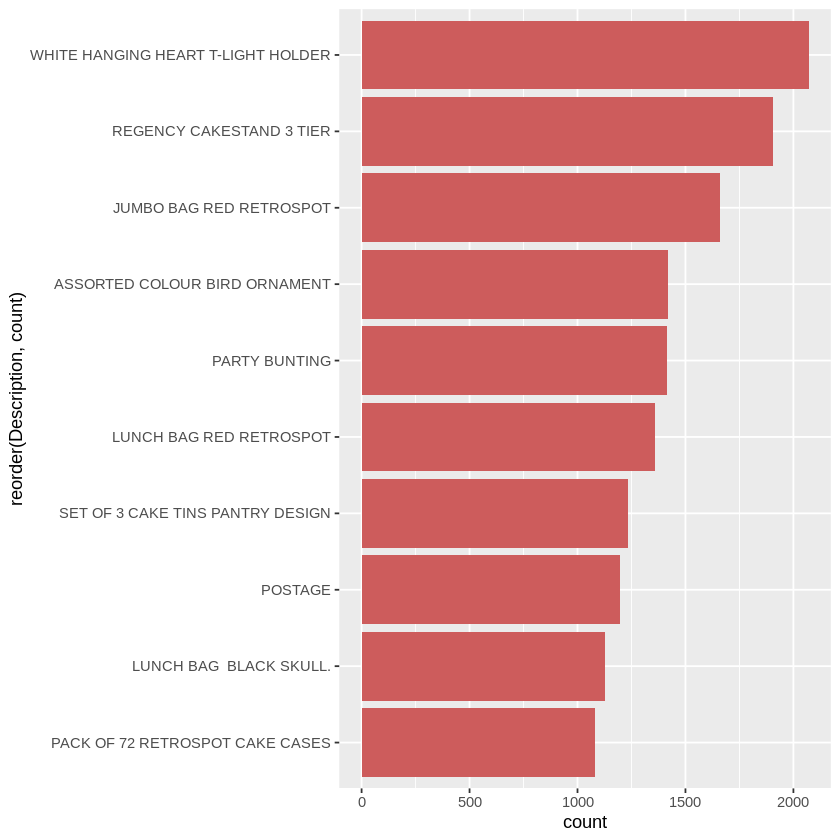

In [ ]:
top <- retail %>%
  group_by(StockCode, Description) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

top <- head(top,10)

top %>%
  ggplot(aes(x=reorder(Description,count), y=count))+
    geom_bar(stat="identity", fill="indian red") +
    coord_flip()




# Transforming the data for association rules
Before using any rule mining algorithm, we need to transform the data from the data frame format, into transactions such that we have all the items bought together in one row.

For that, we can use the ddply(). The function ddply() accepts a data frame, splits it into pieces based on one or more factors, computes on the pieces, and then returns the results as a data frame. We use “,” to separate different items.







In [ ]:
retail_sorted <- retail[order(retail$CustomerID),]

itemList <- ddply(retail,c("CustomerID","Date"),
                       function(df1)paste(df1$Description,
                       collapse = ","))


This ddply function splits the 'retail' dataset into subsets based on the unique combinations of 'CustomerID' and 'Date'.

Then, it applies the function to each subset. In this case, it concatenates the 'Description' column values within each subset into a single string, separated by commas. This is done using the paste() function with collapse = ",".

What we have now is a dataframe with three columns. CustomerID, Date, and a third column with all the descriptions from each subset separated by commas.

In [ ]:
head(itemList,2)

,CustomerID,Date,V1
,<dbl>,<date>,<chr>
1,12346,2011-01-18,"MEDIUM CERAMIC TOP STORAGE JAR,MEDIUM CERAMIC TOP STORAGE JAR"
2,12347,2010-12-07,"BLACK CANDELABRA T-LIGHT HOLDER,AIRLINE BAG VINTAGE JET SET BROWN,COLOUR GLASS. STAR T-LIGHT HOLDER,MINI PAINT SET VINTAGE,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,PINK DRAWER KNOB ACRYLIC EDWARDIAN,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,RED DRAWER KNOB ACRYLIC EDWARDIAN,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,ALARM CLOCK BAKELIKE CHOCOLATE,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE ORANGE,FOUR HOOK WHITE LOVEBIRDS,BLACK GRAND BAROQUE PHOTO FRAME,BATHROOM METAL SIGN,LARGE HEART MEASURING SPOONS,BOX OF 6 ASSORTED COLOUR TEASPOONS,BLUE 3 PIECE POLKADOT CUTLERY SET,RED 3 PIECE RETROSPOT CUTLERY SET,PINK 3 PIECE POLKADOT CUTLERY SET,EMERGENCY FIRST AID TIN,SET OF 2 TINS VINTAGE BATHROOM,SET/3 DECOUPAGE STACKING TINS,BOOM BOX SPEAKER BOYS,RED TOADSTOOL LED NIGHT LIGHT,3D DOG PICTURE PLAYING CARDS,BLACK EAR MUFF HEADPHONES,CAMOUFLAGE EAR MUFF HEADPHONES"


We don't need the first two columns, only the items columns. Later, we will save it to a csv file.

In [ ]:
itemList$CustomerID <- NULL
itemList$Date <- NULL
colnames(itemList) <- c("items")



In [ ]:
write.csv(itemList,"market_basket.csv", quote = FALSE, row.names = TRUE)

We removed the name columns, so it only had items from the first row:


```
# MEDIUM CERAMIC TOP STORAGE JAR,MEDIUM CERAMIC TOP STORAGE JAR,
#BLACK CANDELABRA T-LIGHT HOLDER,AIRLINE BAG VINTAGE JET SET BROWN,COLOUR GLASS. STAR T-LIGHT HOLDER,MINI PAINT SET VINTAGE,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,PINK DRAWER KNOB ACRYLIC EDWARDIAN,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,RED DRAWER KNOB ACRYLIC EDWARDIAN,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,ALARM CLOCK BAKELIKE CHOCOLATE,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE ORANGE,FOUR HOOK  WHITE LOVEBIRDS,BLACK GRAND BAROQUE PHOTO FRAME,BATHROOM METAL SIGN,LARGE HEART MEASURING SPOONS,BOX OF 6 ASSORTED COLOUR TEASPOONS,BLUE 3 PIECE POLKADOT CUTLERY SET,RED 3 PIECE RETROSPOT CUTLERY SET,PINK 3 PIECE POLKADOT CUTLERY SET,EMERGENCY FIRST AID TIN,SET OF 2 TINS VINTAGE BATHROOM,SET/3 DECOUPAGE STACKING TINS,BOOM BOX SPEAKER BOYS,RED TOADSTOOL LED NIGHT LIGHT,3D DOG PICTURE PLAYING CARDS,BLACK EAR MUFF HEADPHONES,CAMOUFLAGE EAR MUFF HEADPHONES
```






This is the format that the transactions function (`arules` package) needs to read a dataset as a basket.

In [ ]:
tr <- read.transactions('/content/market_basket (1).csv', format = 'basket', sep=',')
tr
summary(tr)

Streaming output truncated to the last 5000 lines.
Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
“EOF within quoted string”
Warning message in scan(text = l, what = "character", sep = sep, quote = quote, :
“EOF within quoted string”
Warning message in asMethod(object):
“removing duplicated items in transactions”


transactions in sparse format with
 19296 transactions (rows) and
 7974 items (columns)

transactions as itemMatrix in sparse format with
 19296 rows (elements/itemsets/transactions) and
 7974 columns (items) and a density of 0.002073209 

most frequent items:
WHITE HANGING HEART T-LIGHT HOLDER           REGENCY CAKESTAND 3 TIER 
                              1716                               1630 
           JUMBO BAG RED RETROSPOT                      PARTY BUNTING 
                              1400                               1225 
     ASSORTED COLOUR BIRD ORNAMENT                            (Other) 
                              1217                             311809 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2697 1167  831  753  715  651  604  584  574  544  563  501  485  498  497  493 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 440  408  470  409  366  299  304  263  229  244  215  195  216  211  170  139 
  33   34   35   36 

We see 19,296 transactions, and this is the number of rows as well. There are 7,974  items — remember items are the product descriptions in our original dataset. Transactions here are the collections or subsets of these 7,974  items.

The summary gives us some useful information:

* density: The percentage of non-empty cells in the sparse matrix. In another words, the total number of items that are purchased divided by the total number of possible items in that matrix. We can calculate how many items were purchased using density like so: 19296 X 7881 X 0.0022
* The most frequent items should be the same as our results in Figure 3. And they are!
* Looking at the size of the transactions: 2697 transactions were for just 1 item, 1167 transactions for 2 items, all the way up to the biggest transaction: 1 transaction for 401 items. This indicates that most customers buy a small number of items in each transaction.

#Creating some rules for the Algorithm

* We use the `Apriori` algorithm in `Arules` library to mine frequent itemsets and association rules. The algorithm employs level-wise search for frequent itemsets.

* We pass supp=0.001 and conf=0.8 to return all the rules that have a support of at least 0.1% and confidence of at least 80%.
* We sort the rules by decreasing confidence.
* Have a look at the summary of the rules.

In [ ]:
rules <- apriori(tr, parameter = list(supp=0.001, conf=0.8))
rules <- sort(rules, by='confidence', decreasing = TRUE)
summary(rules)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 19 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[7974 item(s), 19296 transaction(s)] done [0.19s].
sorting and recoding items ... [2362 item(s)] done [0.01s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10

Warning message in apriori(tr, parameter = list(supp = 0.001, conf = 0.8)):
“Mining stopped (maxlen reached). Only patterns up to a length of 10 returned!”


 done [0.38s].
writing ... [59081 rule(s)] done [0.04s].
creating S4 object  ... done [0.03s].


set of 59081 rules

rule length distribution (lhs + rhs):sizes
    2     3     4     5     6     7     8     9    10 
  104  2748  8469 20004 17721  7078  2203   641   113 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   5.000   5.000   5.463   6.000  10.000 

summary of quality measures:
    support           confidence        coverage             lift        
 Min.   :0.001036   Min.   :0.8000   Min.   :0.001036   Min.   :  8.996  
 1st Qu.:0.001088   1st Qu.:0.8333   1st Qu.:0.001244   1st Qu.: 20.472  
 Median :0.001244   Median :0.8750   Median :0.001399   Median : 27.633  
 Mean   :0.001432   Mean   :0.8862   Mean   :0.001622   Mean   : 64.622  
 3rd Qu.:0.001555   3rd Qu.:0.9322   3rd Qu.:0.001762   3rd Qu.: 76.876  
 Max.   :0.017568   Max.   :1.0000   Max.   :0.021248   Max.   :622.452  
     count       
 Min.   : 20.00  
 1st Qu.: 21.00  
 Median : 24.00  
 Mean   : 27.63  
 3rd Qu.: 30.00  
 Max.   :339.00  

mining info:
 data ntransactions support confidence
 

The summary of the rules gives us some very interesting information:

* The number of rules: 59,081.
* The distribution of rules by length: a length of 5 items has the most rules.
* The summary of quality measures: ranges of support, confidence, and lift.
* The information on data mining: total data mined, and the minimum parameters we set earlier.

We have 89,697 rules. I don’t want to print them all, so let’s inspect the top 10.



In [ ]:
inspect(rules[1:10])

     lhs                         rhs                support     confidence
[1]  {DECOUPAGE}              => {GREETING CARD}    0.001088308 1         
[2]  {WOBBLY CHICKEN}         => {METAL}            0.001399254 1         
[3]  {WOBBLY CHICKEN}         => {DECORATION}       0.001399254 1         
[4]  {BILLBOARD FONTS DESIGN} => {WRAP}             0.001502902 1         
[5]  {BLACK TEA}              => {SUGAR JARS}       0.002176617 1         
[6]  {BLACK TEA}              => {COFFEE}           0.002176617 1         
[7]  {WOBBLY RABBIT}          => {METAL}            0.001658375 1         
[8]  {WOBBLY RABBIT}          => {DECORATION}       0.001658375 1         
[9]  {CHOCOLATE  SPOTS}       => {SWISS ROLL TOWEL} 0.002072968 1         
[10] {ART LIGHTS}             => {FUNK MONKEY}      0.001813847 1         
     coverage    lift      count
[1]  0.001088308 371.07692 21   
[2]  0.001399254 410.55319 27   
[3]  0.001399254 410.55319 27   
[4]  0.001502902 622.45161 29   
[5]  0.002

So these means that a 100% of customers that bought DECOUPAGE also bought GREETING CARD. The same with WOBBLY CHICKEN and METAL or DECORATION.

Let's visualize it

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



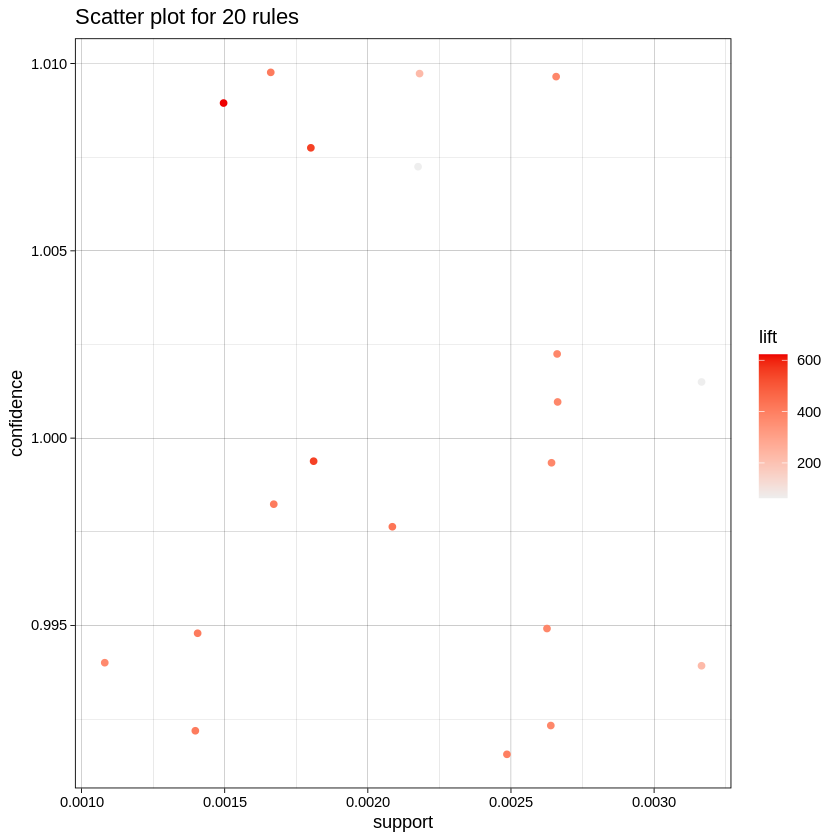

In [ ]:
install.packages("arulesViz")
library(arulesViz)
topRules <- rules[1:20]
plot(topRules)



Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


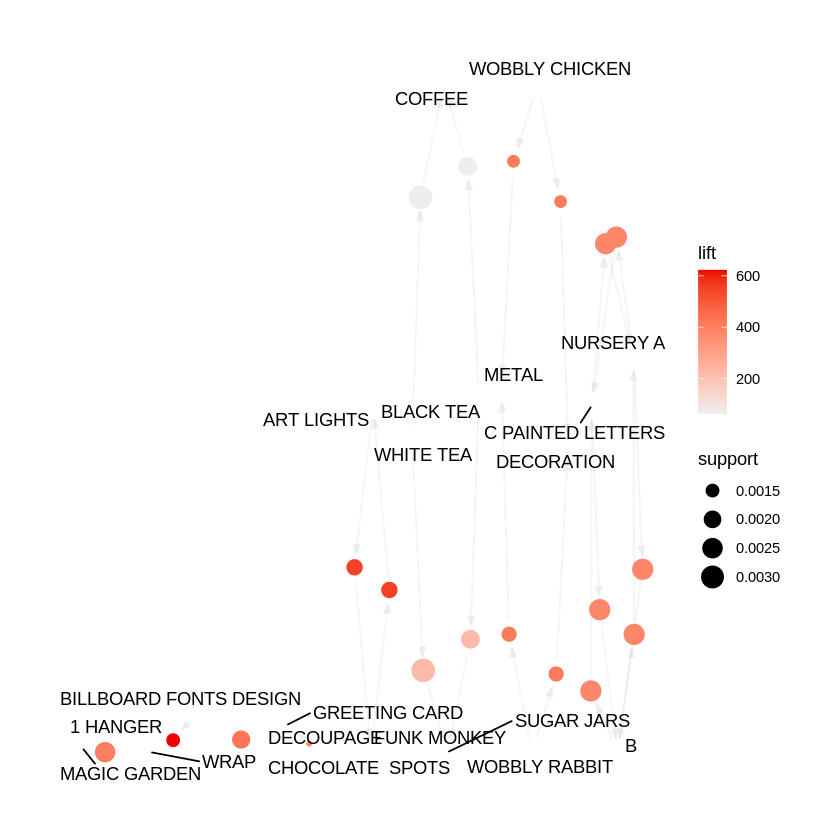

In [ ]:
plot(topRules,method="graph")